# Dependencies

In [ ]:
!python -c 'import tensorflow; print(tensorflow.__version__)'

2020-07-20 14:22:31.808763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.2.0


In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 3.8MB 57.0MB/s 
     |████████████████████████████████| 512kB 53.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e1ab190e52357b71e1ac52a08575872e6797458b9e16a59b2627a99f70c8e819
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

In [85]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras import regularizers, constraints
from keras import backend as K
import tensorflow as tf

# GAN

In [95]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 128
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    def norm_loss(y_real, y_pred):

#-------------------------------------------------------------------------------------------------------------------------
 
      #y_real = tf.linalg.norm(y_real)
      #y_pred = tf.linalg.norm(y_pred)

      #distance_reverse = 1 / (y_real - y_pred)

#-------------------------------------------------------------------------------------------------------------------------
      #squared_distance = tf.keras.losses.mean_squared_error(y_real, y_pred)
      #squared_distance_reverse = 1/squared_distance
#--------------------------------------------------------------------------------------------------------------------------
      squared_distance = tf.square(y_real - y_pred)
      # we want to maximize this distance,
      #However, the labels that we are using, are the inverse of the norm
      #therefore, we do not need to reverse the result of our mean squard error
      squared_distance_reverse = tf.math.sqrt (tf.reduce_mean(squared_distance, axis=-1))
#--------------------------------------------------------------------------------------------------------------------------
      #use log to avoid computing error
      #log_squared_distance_reverse = tf.math.log(1) - tf.math.log((tf.reduce_mean(squared_distance, axis=-1)))
      #squared_distance_reverse = tf.math.exp(log_squared_distance_reverse)
#--------------------------------------------------------------------------------------------------------------------------
      #return 1/(y_real-y_pred)
      return squared_distance_reverse
      #return 1/tf.keras.losses.binary_crossentropy(y_real, y_pred)
      #return 1/tf.keras.losses.mean_squared_error(y_real, y_pred)

#-------------------------------------------------------------------------
    z = Input(shape=(self.latent_dim,))
    #print('--------------------------------')
    #print('This is z :' , z)
    #print('This is z.shape :' , z.shape)
        

#--------------------------------------------------------------------------
    img , distance = self.generator(z)
    #print('--------------------------------')
    #print('Image shape: ', img.shape)
    #print('distance shape: ', distance.shape)

    self.discriminator.trainable = False

#-----------------------------------------------------------------------------
    validity = self.discriminator(img)
    #print('--------------------------------')
    #print('Validity: ', validity)
    #print('--------------------------------')
    #print('Type of validity:', type(validity))

    #self.ditance = tf.convert_to_tensor(np.linalg.norm(img))
    #self.combined = Model((z,distance), (validity, distance))
    
    #self.distance = 1
    #self.combined = Model(z, [self.distance ,validity])
    #self.combined.compile(loss=['binary_crossentropy','binary_crossentropy'], optimizer=optimizer)
    
 
    #distance = tf.linalg.norm(distance)
    self.combined = Model(z, [validity, distance])
    self.combined.compile(loss=['binary_crossentropy' , norm_loss], optimizer=optimizer)
    
  def build_generator(self):
    #functional code
    input_layer = Input(shape=(self.latent_dim,))
    layer = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(512, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(1024, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)

    out1 = Dense(np.prod(self.img_shape), activation='tanh' )(layer)
    out1 = Reshape(self.img_shape)(out1)

    #out2 = GlobalAveragePooling2D()(out1)
    #out2 =  Dense(1, activation='relu')(out2)
    out2 =  Dense(1, activation='relu')(layer)


    noise = input_layer
    img = out1
    distance = out2

    model = Model(noise, [img,distance])
    model.summary()
    return model

    #Sequential code
    #model = Sequential()
    #model.add(Dense(256, input_dim=self.latent_dim))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(1024))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    #model.add(Reshape(self.img_shape))
    #model.summary()
    #noise = Input(shape=(self.latent_dim,))
    #img = model(noise)
    #return Model(noise, img)
        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
#-------------------------------------------------------------------------------------
 #   model.add(MinibatchDiscrimination(4, 4, input_dim = (256,)))
 #   model.add(Reshape((16,16)))
 #   model.add(Flatten())
#------------------------------------------------------------------------------------

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)

  #def distance_of_batches(self):
  #  input_layer = Input(shape=(self.latent_dim,))
  #  layer = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
  #  layer = BatchNormalization(momentum=0.8)(layer)
  #  out =  Dense(1, activation='sigmoid' )(layer)
  #  distances = input_layer
  #  distance = out
  #  model = Model(distances, distance)
  #  model.summary()
  #  return model


  #def train(self, epochs, batch_size=128, sample_interval=60):
  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    
#-------------------------------------------------------------------
    #print('x train [0]:', X_train[0] , ' its shape:', X_train[0].shape) ---------> 28*28

    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    #print('new x train[0] :', X_train[0] , ' its shape:', X_train[0].shape) ------> 28*28*1
      
      
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    #print('--------------------------------')
    #print('valid.shape inside training:', valid.shape)
    #print('--------------------------------')
    #print('fake.shape inside training:', fake.shape)

    for epoch in range(epochs):
      #-------------------------------------------------------------------------
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      #print('--------------------------------')
      #print("this is idx.shape: ", idx.shape)

      imgs = X_train[idx]
      #print('--------------------------------')
      #print('imgs.shape:', imgs.shape)
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      #print('noise:', noise)
      gen_imgs, distances = self.generator.predict(noise)
      #print('gen_imgs', gen_imgs)
      #print('hello')
          
      #-------------------------------------------------------------------------------------------
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      #print('--------------------------------')
      #print('d loss real', d_loss_real)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      #print('--------------------------------')
      #print('d loss fake', d_loss_fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      #print('--------------------------------')
      #print(' d_ loss ' , d_loss)
          
# ------------------------------------------------------------------------------------------------
 #its shape --> zeros
      #mean_samples =   np.zeroes((1, self.latent_dim))
      #for i in range(1, batch_size):
      #  other_samples_noise = np.random.normal(0, 1, (1, self.latent_dim))
      #  mean_samples = mean_samples + noise
      #mean_samples = mean_samples/(batch_size-1)

      #first_sample_noise = noise = np.random.normal(0, 1, (1, self.latent_dim))

      #g_discrimination = 


# --------------------------------------------------------------------------------------------------
 #its shape --> zeros (initialize)
      #mean_samples =   np.zeroes((1, self.latent_dim))
      #max_discrimination = vector
     
      #other_samples_noise = np.random.normal(0, 1, ((batch_size -1), self.latent_dim))
      #mean_samples = other_samples_noise #(jam besham ruye sutun)
      #mean_samples = mean_samples/(batch_size-1) #taghsim beshan be tedad vas miyangin gereftan
        
      #first_sample_noise = np.random.normal(0, 1, (1, self.latent_dim))
      #discrimination = first_sample_noise - mean_samples

      #fake_generated_sample_1 = self.generator.predict(first_sample_noise)
      #fake_generated_sample_2 = self.generator.predict(discrimination)

      #use mean squer for calculating the distance
      #discrimination = fake_generated_sample_1 - fake_generated_sample_2

      #g_discrimination = 
# ------------------------------------------------------------------------------------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

# ------------------------------------------------------------------------------------------------
      #fake_images = self.generator.predict(noise)
      #g_loss_discrimination = 1/(np.linalg.norm(fake_images))
      #g_loss_discrimination = 1/(np.linalg.norm(fake_images))
      
# ------------------------------------------------------------------------------------------------
 
      #real_data_discrimination = []
      #for i in range(0,len(imgs)):
      #  real_data_discrimination.append(1/(np.linalg.norm(imgs[0]))) 
      #real_data_discrimination = np.array(real_data_discrimination)
# ------------------------------------------------------------------------------------------------

      fake_data_discrimination = []

      for i in range(0,len(gen_imgs)):
        other_generated_images = []
        for j in range(0,len(gen_imgs)):
          #for each generated data, we should consider the distance beween this sample with others (not itself)
          if j!=i:
            other_generated_images.append(gen_imgs[j])

        fake_data_discrimination.append(1/(np.linalg.norm(other_generated_images))) 
      fake_data_discrimination = np.array(fake_data_discrimination)
# ------------------------------------------------------------------------------------------------
 
      #real_data_discrimination = 1/(np.linalg.norm(imgs))
      #real_data_discrimination = np.expand_dims(real_data_discrimination, axis = 1)
      #real_data_discrimination = (np.linalg.norm(imgs))
      #print('real_data_discrimination.shape: ',real_data_discrimination.shape)
      #print('real data discrimination:',  real_data_discrimination , " vs generated data discrimination: ", g_loss_discrimination)
# ------------------------------------------------------------------------------------------------
 
      #sigma = 0.8
      #new_noise = (noise + g_loss_discrimination)/sigma**2


      #print('first loss discrimination : ', g_loss_discrimination)

      #while g_loss_discrimination < 0.001:
      #  noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      #  fake_images = self.generator.predict(noise)
      #  g_loss_discrimination = 1/(np.linalg.norm(fake_images))

      #print('loss discrimination after while :', g_loss_discrimination)
      
      # generator train on batch (generator with two out put)
# ------------------------------------------------------------------------------------------------

      #g_loss = self.combined.train_on_batch(noise, valid)

      #g_loss = self.combined.train_on_batch(noise, [valid,real_data_discrimination])
      
      g_loss = self.combined.train_on_batch(noise, [valid,fake_data_discrimination])
      
      #g_loss = self.combined.train_on_batch((noise, g_loss_discrimination ) , (valid, g_loss_discrimination))
      
      #g_loss = self.combined.train_on_batch(new_noise, valid)

      #g_loss = self.combined.train_on_batch(new_noise,[g_loss_discrimination, valid])
      
      

# ------------------------------------------------------------------------------------------------
      #g_loss_new = g_loss * g_loss_discrimination
      #print('g_loss_new:' , g_loss_new)
# ------------------------------------------------------------------------------------------------


      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G loss: %f loss]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs, distances = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()

In [96]:
if __name__ == '__main__':
    gan = GAN()
    #gan.train(epochs=20000, batch_size=64, sample_interval=1000)
    gan.train(epochs=1000, batch_size=64, sample_interval=100)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_151 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_242 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_90"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
dense_243 (Dense)               (None, 256)          33024       input_91[0][0]                   
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 256)          1024        dense_243[0][0]                  
__________________________________________________________________________________________________
dense_244 (Dense)               (None, 512)          131584      batch_normalization_91[0][0]     
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.149973, acc.: 25.00%] [G loss: 1.289932, G loss: 0.775863 loss]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.414518, acc.: 90.62%] [G loss: 1.223882, G loss: 0.750411 loss]
2 [D loss: 0.344035, acc.: 88.28%] [G loss: 1.322081, G loss: 0.822424 loss]
3 [D loss: 0.314508, acc.: 89.84%] [G loss: 1.332336, G loss: 0.861232 loss]
4 [D loss: 0.306923, acc.: 90.62%] [G loss: 1.437546, G loss: 0.953524 loss]
5 [D loss: 0.277634, acc.: 94.53%] [G loss: 1.500054, G loss: 1.046934 loss]
6 [D loss: 0.253349, acc.: 96.09%] [G loss: 1.621387, G loss: 1.153616 loss]
7 [D loss: 0.239044, acc.: 96.88%] [G loss: 1.724642, G loss: 1.302637 loss]
8 [D loss: 0.192713, acc.: 100.00%] [G loss: 1.806403, G loss: 1.436041 loss]
9 [D loss: 0.173208, acc.: 100.00%] [G loss: 1.957261, G loss: 1.626354 loss]
10 [D loss: 0.142678, acc.: 100.00%] [G loss: 2.084588, G loss: 1.751309 loss]
11 [D loss: 0.125982, acc.: 100.00%] [G loss: 2.212989, G loss: 1.876968 loss]
12 [D loss: 0.118607, acc.: 100.00%] [G loss: 2.287050, G loss: 1.948552 loss]
13 [D loss: 0.105116, acc.: 100.00%] [G loss: 2.290810, G loss: 2.01

with norm loss to maximize the distance between one generated sample and other generated samples using mean square error (The model have two output, first out put is image, second output is distance which is independent to the first output.)

1000 epoch

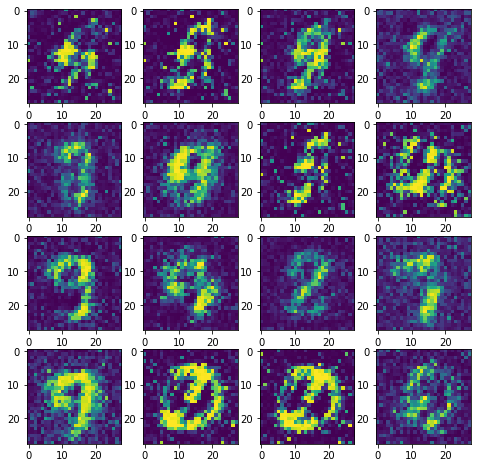

In [97]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

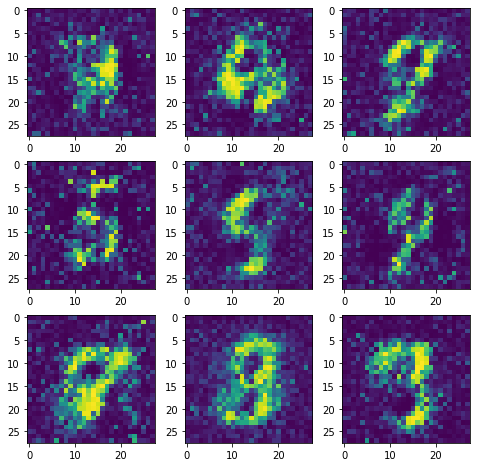

In [98]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples using mean square error (The model have two output, first out put is image, second output is the result of apllying global pooling on the image and then a dense to generate a distance output.)

1000 epoch

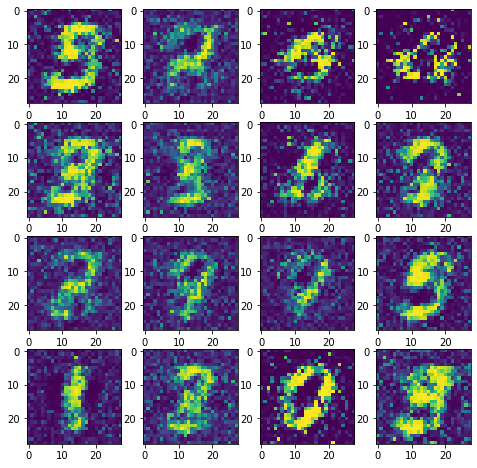

In [93]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

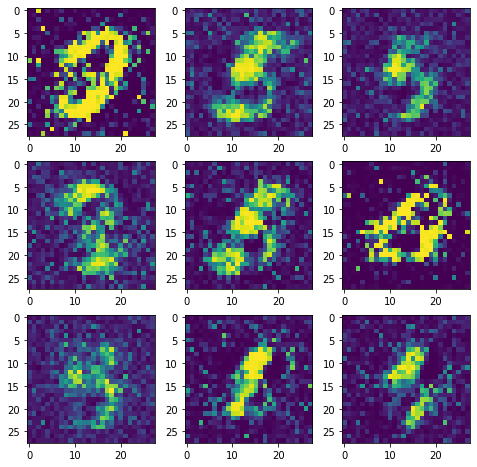

In [94]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples using the reverse of the mean squar error

5000 epoch

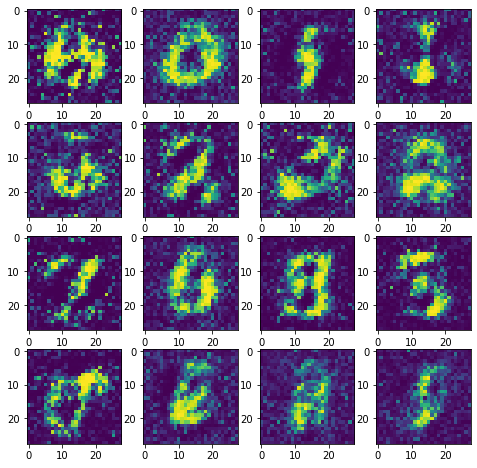

In [78]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples using the reverse of the entropy loss

5000 epoch

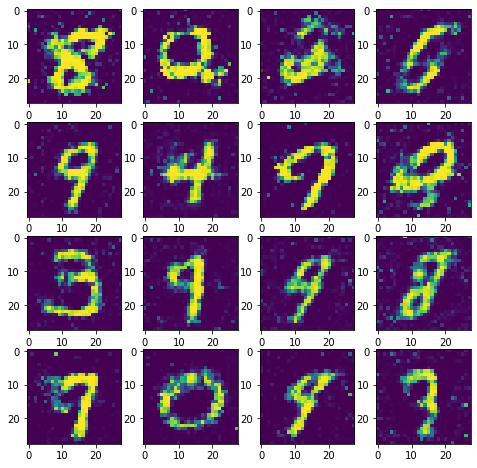

In [65]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

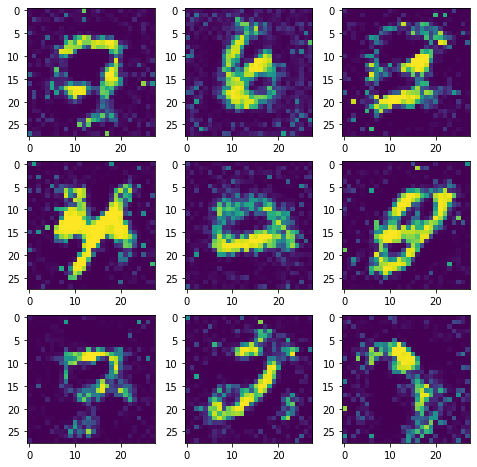

In [70]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

1000 epoch

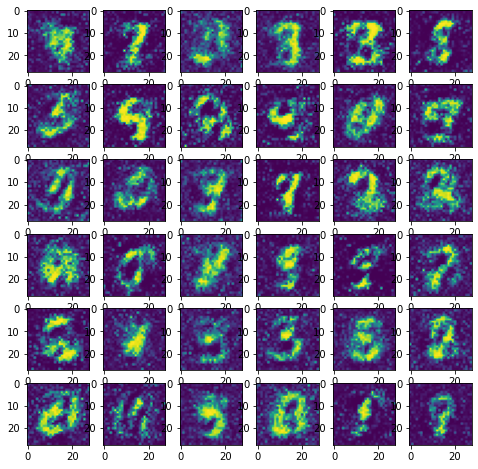

In [62]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

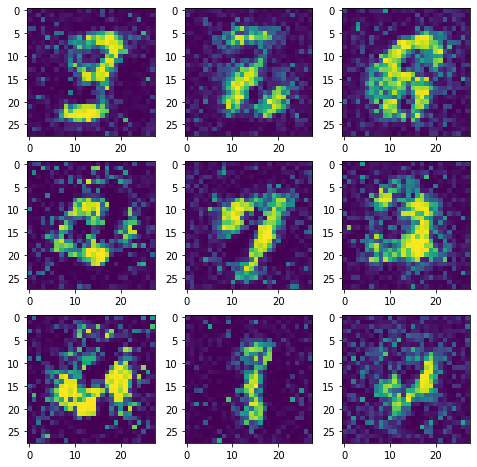

In [63]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples (using the reverse of the distance of norm of the input and output)

10000 epoch

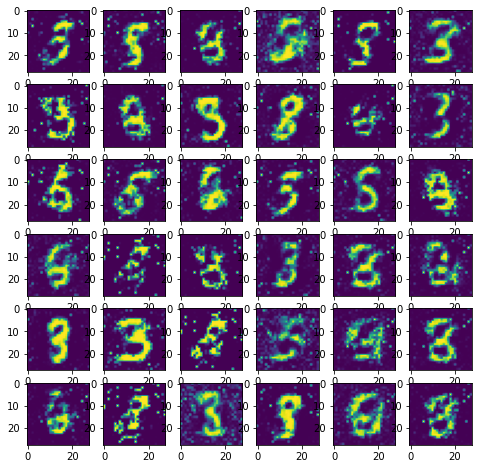

In [51]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

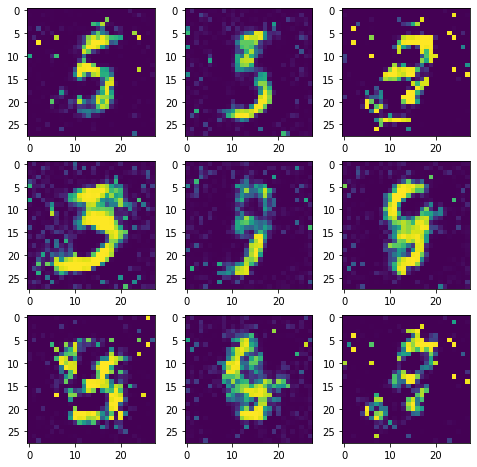

In [55]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

1000 epoch

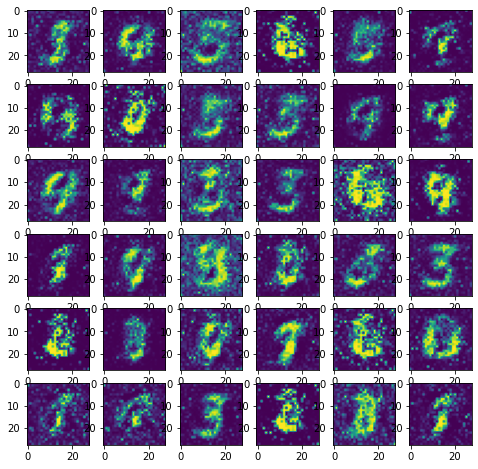

In [49]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples (usong keras mean square error)

1000 epoch

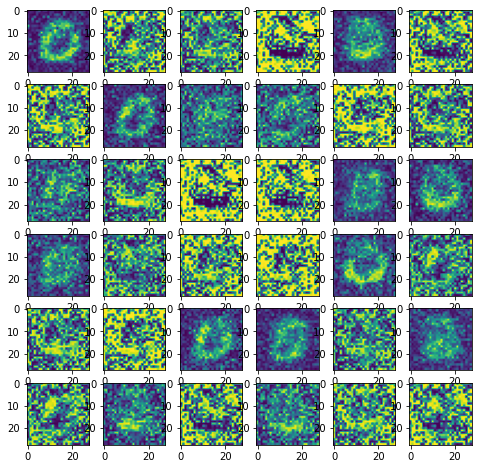

In [43]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

with norm loss to maximize the distance between one generated sample and other generated samples

1000 epoch

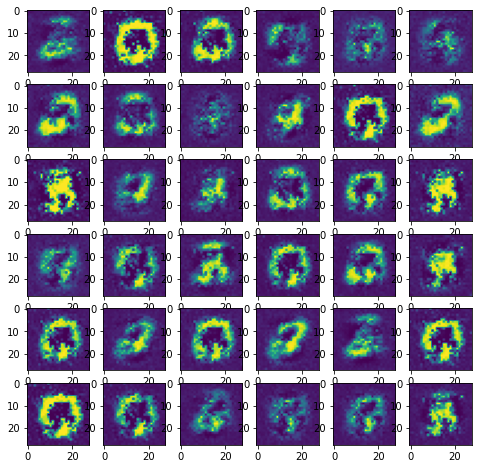

In [36]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

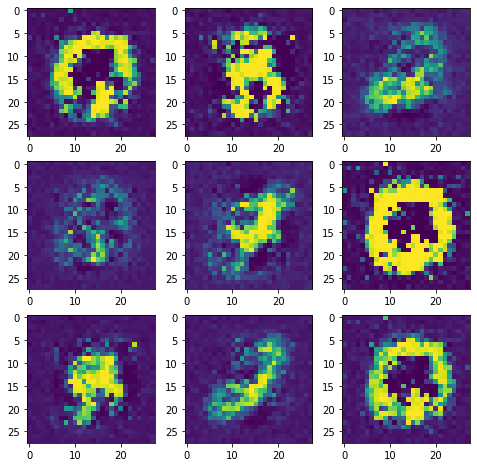

In [37]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

3000 epoch

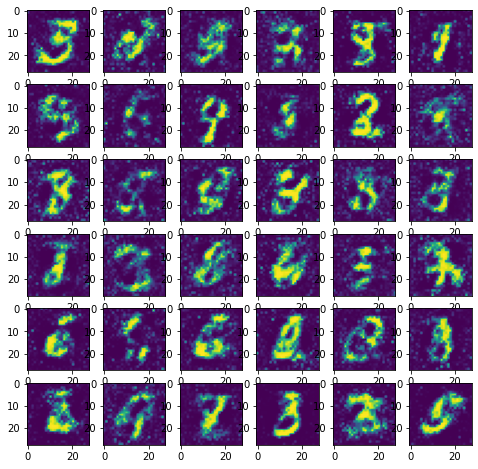

In [32]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

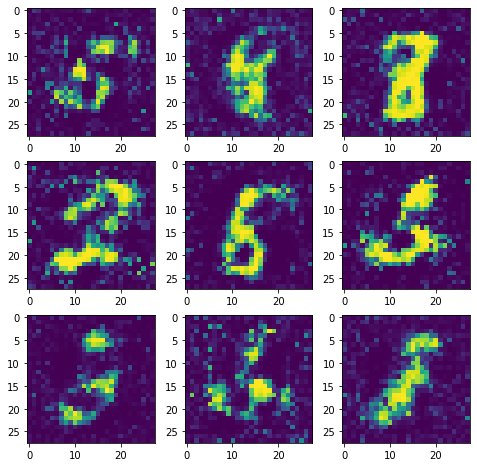

In [34]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

20000

With norm loss to find the distance between the generated data distance and real data distance

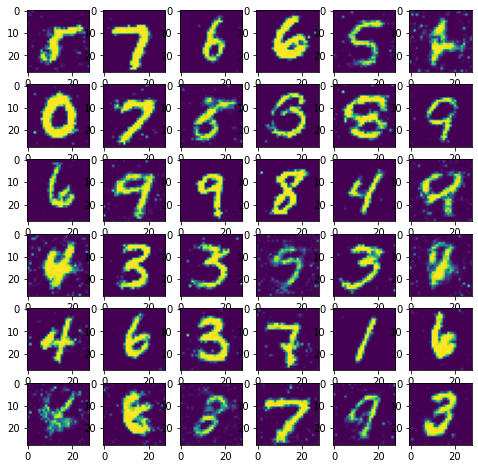

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

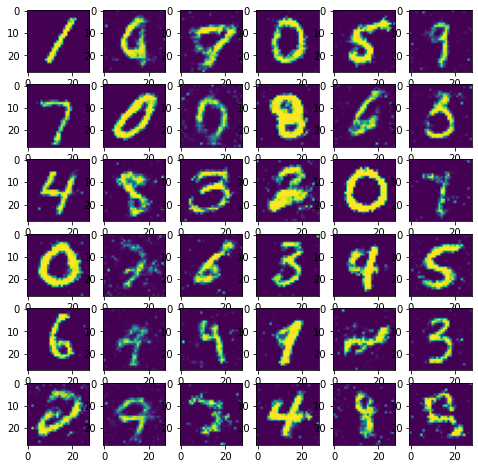

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

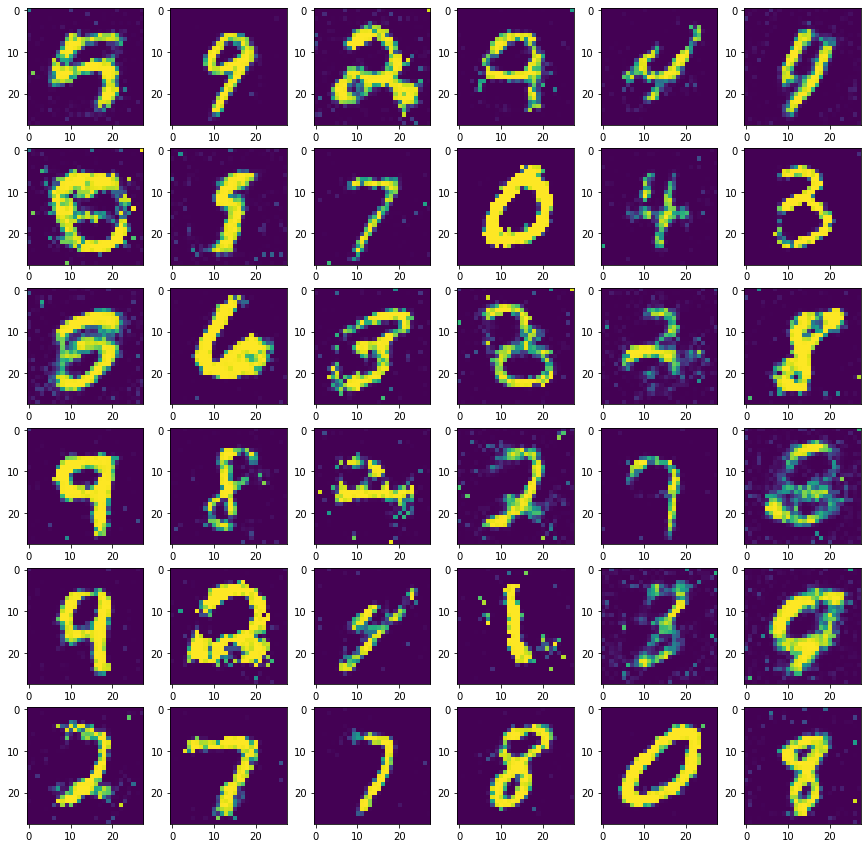

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

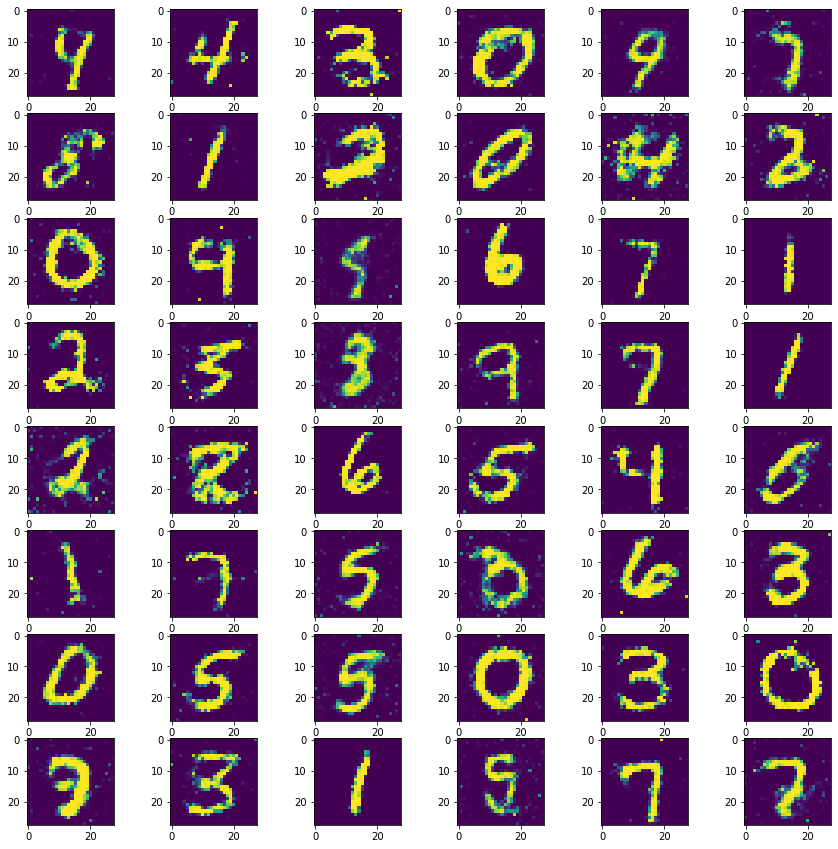

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (48,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 8
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
# 1 2 3 4 5 6 7 8 9

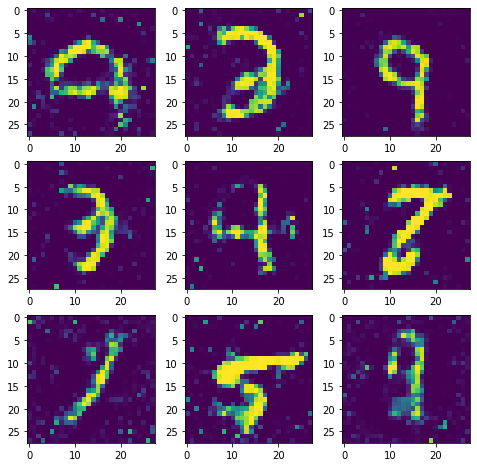

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
# 1 2 3 4 5 6 7 8 9

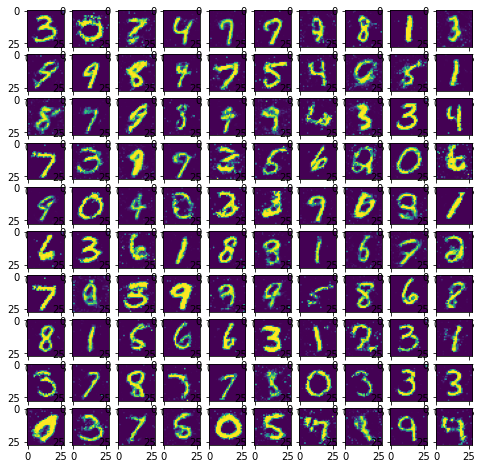

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (100,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
#0 1 2 3 4 5 6 7 8 9

10000 epochs

Get two outputs from generator, Imgs and Distance

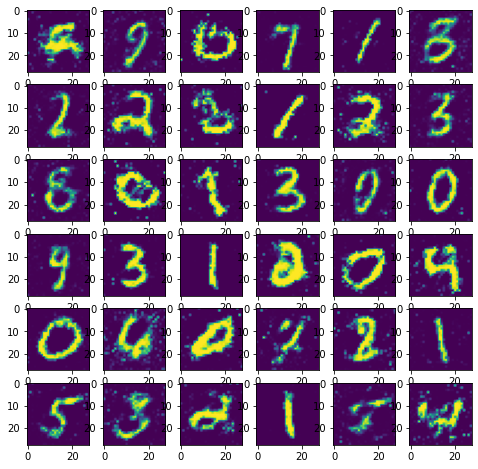

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

Newnoise with sigma = 0.8

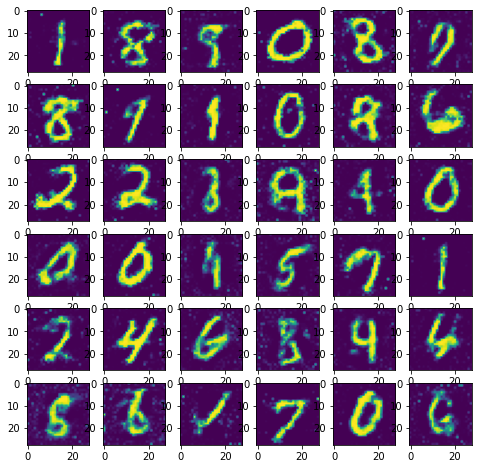

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

1000 epochs:

Newnoise with sigma = 0.8

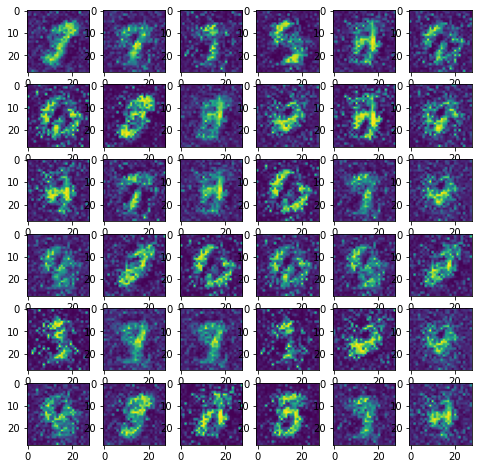

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

newnoise_with sigma = 0.5

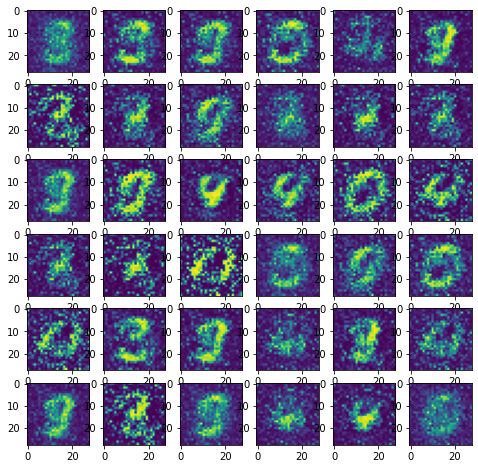

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

New noise with plus

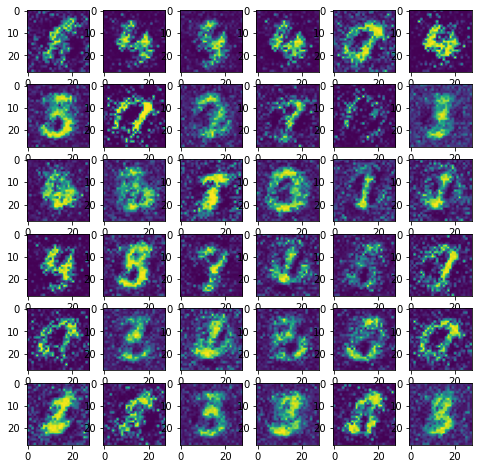

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

New noise with mines

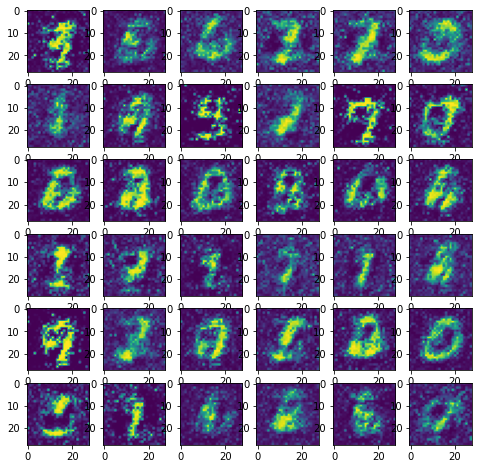

In [ ]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

Model with new noise (with multiply):

In [ ]:
noise = np.random.normal(0, 1, (20,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

(20, 28, 28, 1)

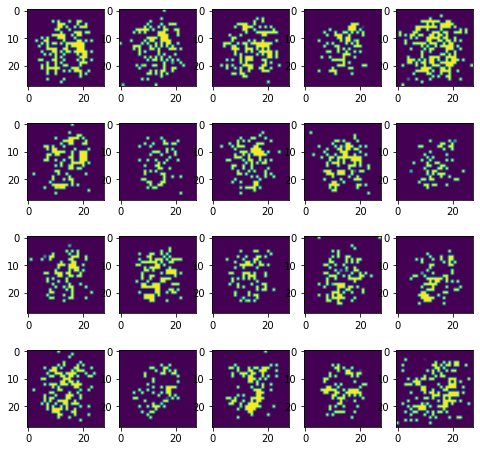

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

Baseline:

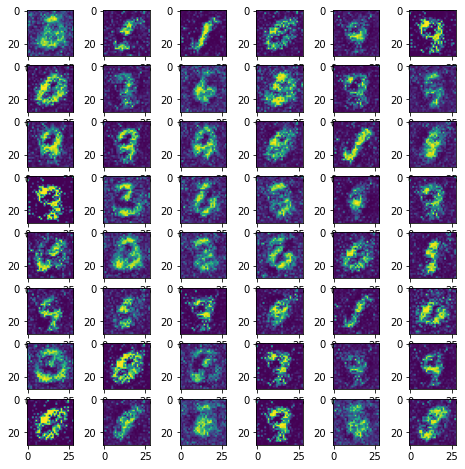

In [ ]:
noise = np.random.normal(0, 1, (48,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 8
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

Model with while:

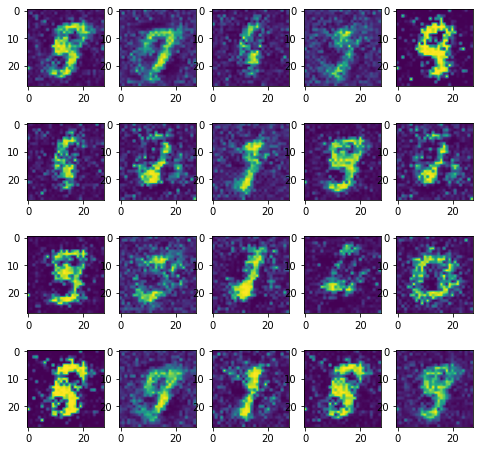

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

# Extra

In [ ]:
noise = np.random.normal(0, 1, (64, 100))
gen_imgs = gan.generator.predict(noise)
g_loss_discrimination = -np.linalg.norm(gen_imgs)
g_loss_discrimination

-43.594784